<img src="https://github.com/sobester/ADRpy/raw/master/docs/ADRpy/ADRpy_splash.png" width="40%" align="left">

*Given a general layout (perhaps one of several candidates at this stage) and some idea of the maximum take-off weight, the next major step of the conceptual design process is the constraint analysis, which will yield the required wing area and thrust - effectively giving 'scale' to the concept.*

*The constraint analysis establishes the boundaries of the feasible part of the thrust to weight ratio (T/W) versus wing loading (W/S) space. Each element of the mission of the aircraft 'bites out' a chunk from this space and the final aeroplane we will progress to the subsequent stages of the design process will have to 'live' in the remaining subspace - generally at the lowest thrust/smallest wing point of the remaining feasible chunk.*

*In this notebook we explore how the constraintanalysis module approaches modelling a key component of drag, the* **lift-induced drag** *, and the know-how required to understand what's going on behind the scenes.*

# Estimating the Induced Drag Factor with ADRpy

## Drag Composition and Drag Polar

The drag force an aircraft encounters during flight is the sum of the drag forces that can be divided into the following categories:

$$D_{total} = D_{parasite} + D_{induced} + \big{[}D_{wave}\big{]}_{M > 1}$$

Where parasite drag is the sum of pressure/form, skin friction, and interference drag effects, induced drag is the pressure drag from induced-downwash vortex development, and wave drag is a supersonic phenomena encompassing drag due to the generation of shockwaves. In terms of aerodynamic coefficients:

$$D = \frac{1}{2} \rho V^2 S C_D$$

$$\implies C_{D,total} = C_{D,parasite} + C_{D,induced} + \big{[}C_{D,wave}\big{]}_{M > 1}$$

The coefficients of profile and wave drag can be broken down further into lift-independent (zero-lift) $C_{D_0}$ and lift-dependent (lift-induced) $C_{D_i}$ components:

$$C_{D,{parasite}} = \begin{cases} 
C_{D_{0}, parasite}\\
C_{D_{i}, parasite}\\
\end{cases}$$

$$C_{D,{induced}} = C_{D_{i}, induced}$$

$$C_{D,{wave}} = \begin{cases} 
C_{D_{0}, wave}\\
C_{D_{i}, wave}\\
\end{cases}$$

The aerodynamic coefficient of drag $C_D$ of a wing, may now be written as the sum of zero-lift $(C_{D_0})$ and lift-induced $(C_{D_{i}})$ components of the profile, induced, and wave drags:

$$C_{D_{0}} = C_{D_{0}, parasite} + {\big{[}C_{D_{0}, wave}}\big{]}_{M > 1}$$

$$C_{D_{i}} = C_{D_{i}, parasite} + C_{D_{i}, induced} + {\big{[}C_{D_{i}, wave}}\big{]}_{M > 1}$$

$$\implies C_D = C_{D_{0}} + C_{D_{i}}$$

Classical wing theory tells us $C_{D_{i}, induced}$ vortex drag may be written as a function of the square of the lift coefficient $C_L$, the aspect ratio $AR$, and a span efficiency factor $e$ due to a departure $\delta$ from the elliptical lift distribution loading case:

$$e = \frac{1}{1 + \delta} \hspace{1cm} [\delta \geq 0]$$

$$\implies C_D = C_{D_{0}} + \frac{{C_L}^2}{\pi AR e} + C_{D_{i}, parasite} + {\big{[}C_{D_{i}, wave}\big{]}}_{M > 1}$$

Assuming the lift-induced components of $D_{profile}$ and $D_{wave}$ also have quadratic dependence on $C_L$, we can introduce the Oswald span efficiency factor $e_0$:

$$C_D = C_{D_{0}} + \frac{{C_L}^2}{\pi AR}\bigg{(}\frac{1}{e} + \pi AR \big{(}c_{d_{i}, parasite} + {\big{[}c_{d_{i}, wave}}\big{]}_{M > 1}\big{)}\bigg{)}$$

$$C_D = C_{D_{0}} + \frac{{C_L}^2}{\pi AR e_0}$$

Which has given us the 'drag polar', and can be rewritten through the substitution of an induced drag factor $K$:

$$ K = \frac{1}{\pi AR e_0}$$

$$\implies C_D = C_{D_{0}} + K{C_L}^2$$

## Estimating 'K' for Subsonic Aircraft: The Oswald efficiency number

For a fixed-wing aircraft we can assume $AR$ to be constant, such that $K = f({e_0})$. It now becomes necessary to estimate $e_0$, for which there are several empirical approximations:



##### Raymer, Aircraft Design -- a Conceptual Approach, AIAA Education Series

$$e_{0, straightwing} = 1.78(1-0.045 \cdot AR^{0.68}) - 0.64$$

*Implemented as* `oswaldspaneff1`

##### Brandt et al, Introduction to Aeronautics -- a Design perspective, AIAA Education Series

$$e_0 = \frac{2}{2 - AR + \sqrt{4 + AR^2(1 + \tan^2 \Lambda_{MT})}}$$

where $\Lambda_{MT}$ is the sweep angle of the maximum thickness chord station.

*Implemented as* `oswaldspaneff2`

##### Raymer, Aircraft Design -- a Conceptual Approach, AIAA Education Series

$$e_{0, sweptwing} = 4.61(1-0.045 \cdot AR^{0.68})(\cos\Lambda_{LE})^{0.15} - 3.1 \hspace{1cm}[\Lambda_{LE} > 30^{\circ}]$$

where $\Lambda_{LE}$ is the sweep angle of the leading edge.

*Implemented as* `oswaldspaneff3`

##### Nita  and Scholz, Estimating the Oswald Factor from Basic Aircraft Geometrical Parameters
A taper ratio $\lambda$ correction:

$$\Delta \lambda = -0.357 + 0.45 \cdot exp(-0.0375 \cdot \Lambda_{25, deg})$$

$$\lambda_H = \lambda - \Delta \lambda$$

where $\Lambda_{25, deg}$ is the sweep angle of the quarter-chord line in degrees.

Hoerner's inviscid span efficiency estimate:

$$\frac{\delta}{AR} = 0.0524{(\lambda_H)}^4 - 0.15{(\lambda_H)}^3 + 0.1659{(\lambda_H)}^2 -0.0706{(\lambda_H)}  + 0.0119 $$

$$e = \frac{1}{1 + \big{(}\frac{\delta}{AR}\big{)}AR}$$

Correction for Fuselage presence:

$$k_{e, F} = 1 - 2 {\bigg{(}\frac{d_F}{b}\bigg{)}}^2 \hspace{1cm} \bigg{[}\frac{d_F}{b}=0.114\bigg{]}$$

where $d_F / b$ is the ratio of fuselage diameter to wingspan, and is given as the average of a sample of GA aircraft.

Correction for viscous drag from lift:

$$k_{e, D_0} = 0.85$$

Correction for compressibility effects, based on empirical fit of subsonic transport aircraft :

$$k_{e, M} = \begin{cases}
M_{\infty} \leq 0.3: 1\\
M_{\infty} > 0.3: 1 - 0.001521 {\big{(}\frac{M_{\infty}}{0.3}-1\big{)}}^{10.82}\\
\end{cases}$$

where $M_{\infty}$ is the free-stream Mach number.

Finally, the Oswald efficiency number:

$$e_0 = e \cdot k_{e, F} \cdot k_{e, D_0} \cdot k_{e, M}$$

*Implemented as* `oswaldspaneff4`

#### Finding K (Mach Invariant)

These equations are implemented separately as `oswaldspaneff1`, `oswaldspaneff2`, `oswaldspaneff3`, `oswaldspaneff4` respectively, and can be found in `induceddragfact` in the `AircraftConcept` class (the latter method takes the `whichoswald` argument, where the user can specify whether to use one of the four equations (e.g., `whichoswald=2` for Brandt et al) or average several of them (e.g., `whichoswald=123` yields an average of the first three).

Use of the equations and their corresponding, resultant induced drag factor estimates are demonstrated below.

In [1]:
# Make sure we have a copy of ADRpy!
from ADRpy import constraintanalysis as ca

In [2]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

matplotlib.rcParams['figure.dpi'] = 160

# Aspect ratio (AR) range to be swept
ar_range = np.arange(2,35,0.1)
e1 = []; e2 = []; e4 = []; e24 = [] 
k1 = []; k2 = []; k4 = []; k24 = []
for ar in ar_range:
    # Gently swept wing
    exdesign = {'aspectratio':ar, 'sweep_le_deg': 2, 'sweep_mt_deg': 1}
    exconcept = ca.AircraftConcept(brief={}, design=exdesign, performance={}, designatm={})
    k1.append(exconcept.induceddragfact(1))
    k2.append(exconcept.induceddragfact(2))
    k4.append(exconcept.induceddragfact(4, mach_inf=0.3))
    k24.append(exconcept.induceddragfact(24, mach_inf=0.3))
    e1.append(exconcept.oswaldspaneff1())
    e2.append(exconcept.oswaldspaneff2())
    e4.append(exconcept.oswaldspaneff4(mach_inf=0.3))
    e24.append((e2[-1] + e4[-1]) / 2.0)

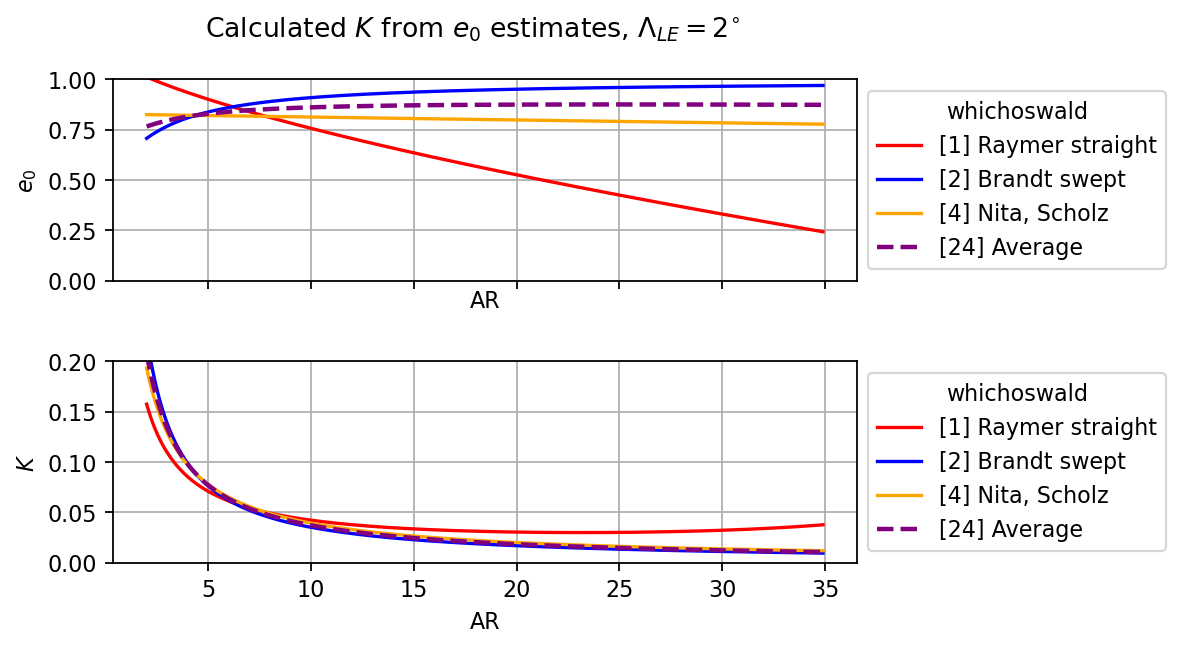

In [3]:
fig, axs = plt.subplots(2, 1, sharex='all', gridspec_kw={'hspace': 0.4})
fig.suptitle("Calculated $K$ from $e_0$ estimates, $\Lambda_{LE}=$"+str(exdesign['sweep_le_deg'])+"$^{\circ}$")

axs[0].plot(ar_range, e1, label='[1] Raymer straight', c='red')
axs[0].plot(ar_range, e2, label='[2] Brandt swept', c='blue')
axs[0].plot(ar_range, e4, label='[4] Nita, Scholz', c='orange')
axs[0].plot(ar_range, e24, label='[24] Average', lw=2, c='purple', ls='--')
axs[0].grid(True)
axs[0].set(xlabel='AR', ylabel='$e_0$')
axs[0].set_ylim(0, 1)
axs[0].legend(title='whichoswald', loc='center left', bbox_to_anchor=(1, 0.5))

axs[1].plot(ar_range, k1, label='[1] Raymer straight', c='red')
axs[1].plot(ar_range, k2, label='[2] Brandt swept', c='blue')
axs[1].plot(ar_range, k4, label='[4] Nita, Scholz', c='orange')
axs[1].plot(ar_range, k24, label='[24] Average', lw=2, c='purple', ls='--')
axs[1].grid(True)
axs[1].set(xlabel='AR', ylabel='$K$')
axs[1].set_ylim(0, 0.2)
axs[1].legend(title='whichoswald', loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

fig.clear()
plt.close(fig=fig)

The above figures show that for a concept aircraft with gentle $\Lambda_{LE} = 2^{\circ}$, `oswaldspaneff2` and `oswaldspaneff4` show very good agreement across the $AR$ investigated. For moderate $AR$ $\sim$ ($4 - 8$) `oswaldspaneff1` shows some agreement with regards to magnitude of prediction, however disagree on the relationship between $e_0$ and $AR$.

`oswaldspaneff1` is strongly dependent on $AR$ to the point where the model actually reaches a finite minimum value of $K$, which would be an optimal design point. This is not a reasonable conclusion to reach given our classical understanding that larger $AR$ is associated with lower $K$, as is a fundamental philosophy in glider aircraft design. For this reason, it is recommended to avoid using the `whichoswald=1` argument outside of moderate $AR$ designs when finding $K$ for straight-wing concepts.

The gentle wing-sweep omits `oswaldspaneff3` from consideration here, as the method is intended for use with wings of $\Lambda_{LE} > 30$.

In [4]:
# Aspect ratio (AR) range to be swept
ar_range = np.arange(1.8,8,0.1)
e2 = []; e3 = []; e4 = []; e234 = [] 
k2 = []; k3 = []; k4 = []; k234 = []
for ar in ar_range:
    # Highly swept wing
    exdesign = {'aspectratio':ar, 'sweep_le_deg': 60, 'sweep_mt_deg': 36}
    exconcept = ca.AircraftConcept(brief={}, design=exdesign, performance={}, designatm={})
    k2.append(exconcept.induceddragfact(2))
    k3.append(exconcept.induceddragfact(3))
    k4.append(exconcept.induceddragfact(4, mach_inf=0.3))
    k234.append(exconcept.induceddragfact(234, mach_inf=0.3))
    e2.append(exconcept.oswaldspaneff2())
    e3.append(exconcept.oswaldspaneff3())
    e4.append(exconcept.oswaldspaneff4(mach_inf=0.3))
    e234.append((e2[-1] + e3[-1] + e4[-1]) / 3.0)

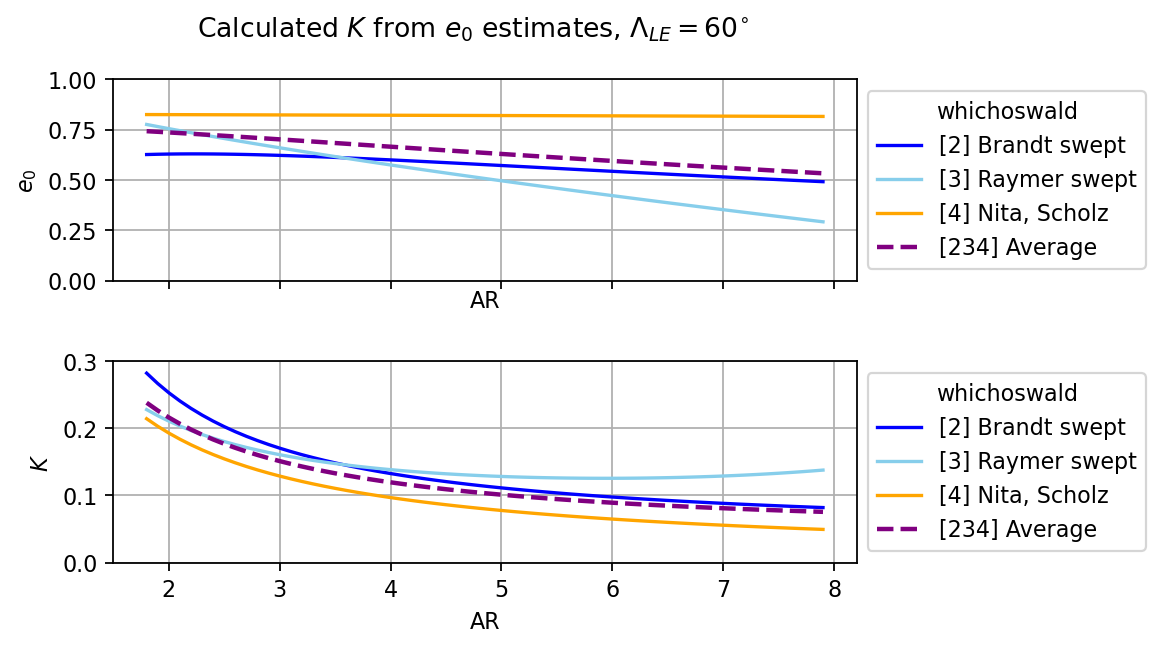

In [5]:
fig, axs = plt.subplots(2, 1, sharex='all', gridspec_kw={'hspace': 0.4})
fig.suptitle("Calculated $K$ from $e_0$ estimates, $\Lambda_{LE}=$"+str(exdesign['sweep_le_deg'])+"$^{\circ}$")

axs[0].plot(ar_range, e2, label='[2] Brandt swept', c='blue')
axs[0].plot(ar_range, e3, label='[3] Raymer swept', c='skyblue')
axs[0].plot(ar_range, e4, label='[4] Nita, Scholz', c='orange')
axs[0].plot(ar_range, e234, label='[234] Average', lw = 2, c='purple', ls='--')
axs[0].grid(True)
axs[0].set(xlabel='AR', ylabel='$e_0$')
axs[0].set_ylim(0, 1)
axs[0].legend(title='whichoswald', loc='center left', bbox_to_anchor=(1, 0.5))

axs[1].plot(ar_range, k2, label='[2] Brandt swept', c='blue')
axs[1].plot(ar_range, k3, label='[3] Raymer swept', c='skyblue')
axs[1].plot(ar_range, k4, label='[4] Nita, Scholz', c='orange')
axs[1].plot(ar_range, k234, label='[234] Average', lw = 2, c='purple', ls='--')
axs[1].grid(True)
axs[1].set(xlabel='AR', ylabel='$K$')
axs[1].set_ylim(0, 0.3)
axs[1].legend(title='whichoswald', loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

fig.clear()
plt.close(fig=fig)

The above diagram visualises the change in $k$ and $e_0$ estimates with $AR$, for a concept high wing-sweep aircraft ($\Lambda_{LE} > 30$). Where high-sweep angles are a common design goal for supersonic aircraft $([\text{F-14}_{AR}=2.58]$; $[\text{EF-111}_{AR}=1.95]$; $[\text{M-2000C}_{AR}=2.03])$, it should then be reasonable to assume these models are best evaluated in low $AR$ use-cases, where the models show good agreement. 

Raymer's model again appears to imply the existence of a finite minimum for $K$, and so it is again recommended to avoid using the `whichoswald=3` argument when estimating $K$ for swept-wing concepts with moderate or larger $AR$.

#### Finding K (Mach Dependent)

The Oswald efficiency estimators `whichoswald=123` provide estimates for $K$, provided $K \neq f(M)$. In reality this is not the case, and the astute observer will have noticed that `oswaldspaneff4` and any method dependent on it (such as `induceddragfact(whichoswald=4)`) aren't *really* Mach independent functions. The Oswald estimate actually contains Mach dependent solutions which can be found by providing the `mach_inf` argument as shown below, but by default `mach_inf=0.3` (which is the case when the method is not explicitly called for using the whichoswald argument).

In [6]:
import math

import numpy as np
import matplotlib
from matplotlib import pyplot as plt

matplotlib.rcParams['figure.dpi'] = 160

# Gently swept wing
exdesign = {'aspectratio':8, 'sweep_le_deg': 2, 'sweep_mt_deg': 1}
exconcept = ca.AircraftConcept(brief={}, design=exdesign, performance={}, designatm={})

# Mach (M) range to be swept
mach_range = np.arange(0,0.9,0.01)
e4 = []; k4 = []
for mach in mach_range:
    # Note how both oswaldspaneff4 and induceddragfact methods can take a Mach number argument
    e4.append(exconcept.oswaldspaneff4(mach_inf=mach))
    k4.append(exconcept.induceddragfact(whichoswald=4, mach_inf=mach))

c:\users\yar1u19\pycharmprojects\aircraftdesignrecipes\venv\lib\site-packages\ADRpy\constraintanalysis.py:583: RuntimeWarning: Specified Mach 0.85 is out of bounds for oswaldspaneff4, e_0 ~= 0
  warnings.warn(calcmsg, RuntimeWarning)
c:\users\yar1u19\pycharmprojects\aircraftdesignrecipes\venv\lib\site-packages\ADRpy\constraintanalysis.py:583: RuntimeWarning: Specified Mach 0.86 is out of bounds for oswaldspaneff4, e_0 ~= 0
  warnings.warn(calcmsg, RuntimeWarning)
c:\users\yar1u19\pycharmprojects\aircraftdesignrecipes\venv\lib\site-packages\ADRpy\constraintanalysis.py:583: RuntimeWarning: Specified Mach 0.87 is out of bounds for oswaldspaneff4, e_0 ~= 0
  warnings.warn(calcmsg, RuntimeWarning)
c:\users\yar1u19\pycharmprojects\aircraftdesignrecipes\venv\lib\site-packages\ADRpy\constraintanalysis.py:583: RuntimeWarning: Specified Mach 0.88 is out of bounds for oswaldspaneff4, e_0 ~= 0
  warnings.warn(calcmsg, RuntimeWarning)
c:\users\yar1u19\pycharmprojects\aircraftdesignrecipes\venv\lib\

**Note:** The above warning(s) are thrown on purpose, to inform the designer that it may not be possible for the aircraft concept to fly at the desired Mach. 

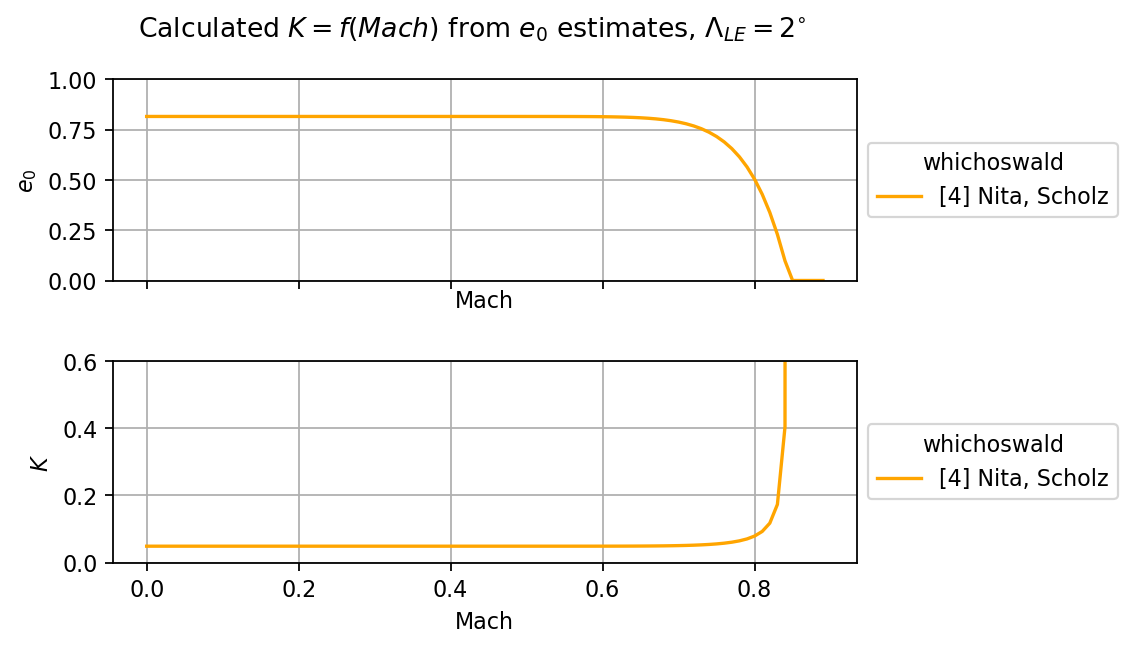

In [7]:
fig, axs = plt.subplots(2, 1, sharex='all', gridspec_kw={'hspace': 0.4})
fig.suptitle("Calculated $K = f(Mach)$ from $e_0$ estimates, $\Lambda_{LE}=$"+str(exdesign['sweep_le_deg'])+"$^{\circ}$")

axs[0].plot(mach_range, e4, label='[4] Nita, Scholz', c='orange')
axs[0].grid(True)
axs[0].set(xlabel='Mach', ylabel='$e_0$')
axs[0].set_ylim(0, 1)
axs[0].legend(title='whichoswald', loc='center left', bbox_to_anchor=(1, 0.5))

axs[1].plot(mach_range, k4, label='[4] Nita, Scholz', c='orange')
axs[1].grid(True)
axs[1].set(xlabel='Mach', ylabel='$K$')
axs[1].set_ylim(0, 0.6)
axs[1].legend(title='whichoswald', loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

fig.clear()
plt.close(fig=fig)

The model is based on performance data of subsonic transport aircraft (aircraft with large radii leading edge wings), and is therefore not recommended for use in evaluating high subsonic or supersonic transport concepts .

## Estimating 'K' for Supersonic Aircraft: Leading-Edge Suction Method

The Mach invariant Oswald methods assume that $K$ is a constant value, whereas in reality, aircraft deviate from $C_L / C_D$ plots as if $K = f(C_L)$. This is because the greater $C_L$ are achieved at greater angle-of-attack $\alpha$, for which $C_{D_{i}parasite}$ viscous separation effects are a strong function of. A fixed $K$ approximation is fine for aircraft with large aerofoil LE radii, but unsuitable for the consideration of thin-wing supersonic aircraft which are far more vulnerable to the separation effects. The following method for determining $K$ in thin-winged supersonic aircraft is taken from 'Aircraft Design -- a Conceptual Approach, AIAA Education Series', by Raymer.

#### K Bounding Case 1: Full-suction

Curvature in an aerofoil results in lower pressure regions that provide a suction effect, keeping incoming air sticking to the curved geometry. For a lifting aerofoil in inviscid flow and free of induced-downwash effects, the LE undergoes a suction force $F_S$ parallel to the chord-line that exactly balances the component of the normal force $N$ aligned with the freestream. This is known as the 100% suction case:

$$F_S \cos \alpha = N \sin \alpha$$

$$S = \frac{F_S \cos \alpha}{N \sin \alpha + C_{D_{total}}} = \frac{N \sin \alpha}{N \sin \alpha} =100 \% \hspace{1cm} \big{[}C_{D,{total}} \vert_{M < 1} = 0\big{]}$$

where $S$ is the suction factor, and $S \in [0, 1]$.

This means the aerofoil experiences no drag force, an idealised 2-D case known as d'Alembert's paradox. An inviscid 3-D wing $(C_{D_{i, induced}} > 0)$ with $\delta=0$ then experiences an Oswald efficiency factor of unity:

$$\frac{1}{e_0} = \frac{1}{\big{(}\frac{1}{1 + \delta}\big{)}} + \pi AR \big{(}c_{d_{i}, parasite} + {\big{[}c_{d_{i}, wave}\big{]}}_{M > 1}\big{)}$$

$$ = (1 + 0) + \pi AR \big{(}0 + 0\big{)} \hspace{1cm} [M < 1]$$

$$ \implies e_0 = 1 $$

Leading to a theoretical lower bound for induced-drag factor $K$, for subsonic real wings in which the 100% suction case applies:

$$ K = \frac{1}{\pi AR e_0} $$

$$ K_{100} = \frac{1}{\pi AR} $$

#### K Bounding Case 2: Zero-suction

Similar to the first case, considering an inviscid and zero induced-downwash flow allows us to negate $C_{D_i}$ effects. On the contrary, a lifting flat-plate with zero-thickness geometry has zero-area surface geometry normal to the chord line, and therefore can not demonstrate LE suction pressure. This is referred to as a 0% suction case:

$$S = \frac{F_S \cos \alpha}{N \sin \alpha + C_{D,{total}}} = \frac{0}{N \sin \alpha} =0 \% \hspace{1cm} \big{[}C_{D,{total}} \vert_{M < 1} = 0; F_S \vert_{flatplate} = 0\big{]}$$

Since any force can only act normal to the chord, $N$ may be decomposed into $L$ and $D_{i}$:

$$L = N \cos \alpha$$

$$D_{i} = N \sin \alpha$$

By non-dimensionalising to aerodynamic coefficients and substituting:

$$C_{D_i} = C_L \tan \alpha$$

Small angle approximation:

$$C_{D_i} = K{C_L}^2 \cong C_L \alpha$$

$$2D \hspace{0.5cm}\rightarrow\hspace{0.5cm} K_{0} = ({C_{L_{\alpha}, 2D}})^{-1} $$

$$3D \hspace{0.5cm}\rightarrow\hspace{0.5cm} K_{0} = ({C_{L_{\alpha}, 3D}})^{-1} $$

where $C_{L_{\alpha}}$ is the lift slope of the aerofoil or wing considered.

#### Determination of Suction Factor S

Given the bounds of $K$ are based on limiting suction cases, we can find $K$ as a suction-weighted average of the limiting cases, from % suction $S$ achieved:

$$K = S \cdot K_{100} + (1 - S) \cdot K_0$$

The suction factor $S$ is a function of the difference in wing design $C_L$ ($C_{L,cruise}$) versus actual $C_L$ achieved. With the intention that this tool be used for conceptual design only, an empirical estimate of $S$ is sufficient. Raymer provides a figure indicating typical suction value goals for supersonic aircraft, which was used as the basis for the ADRpy suction model.

In [8]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

matplotlib.rcParams['figure.dpi'] = 160

# List of actual CL demanded in flight along the x-axis
cl_achieved = np.arange(-1, 2, 0.01)

# List of original design CL
cl_cruise_array = np.array([.0, .1, .3, .4, .5, .6, .8])


# Suction model
def y_suction(cl_delta, cl_crs, a, c, r):
    k = (-0.5 * cl_crs ** 2) - (0.25 * cl_crs) -0.22
    b = 1 + r * k 
    x = cl_delta
    y = a * (x - b) * np.exp(-c * (x - 0.1)) * -np.tan(0.1 * (x - k))
    return y

# Sample suction curves
y_03 = y_suction(cl_delta=cl_achieved, cl_crs=0.3, a=22.5, c=1.95, r=0)
y_08 = y_suction(cl_delta=cl_achieved, cl_crs=0.8, a=5.77, c=1, r=-1.29)

# In the ADRpy constraints module, each cl_cruise is used to find a weighted average of the sample curves:
# weight = np.interp(cl_cruise, [0.3, 0.8], [1, 0])
# y_0x = weight * y_03 + (1 - weight) * y_08

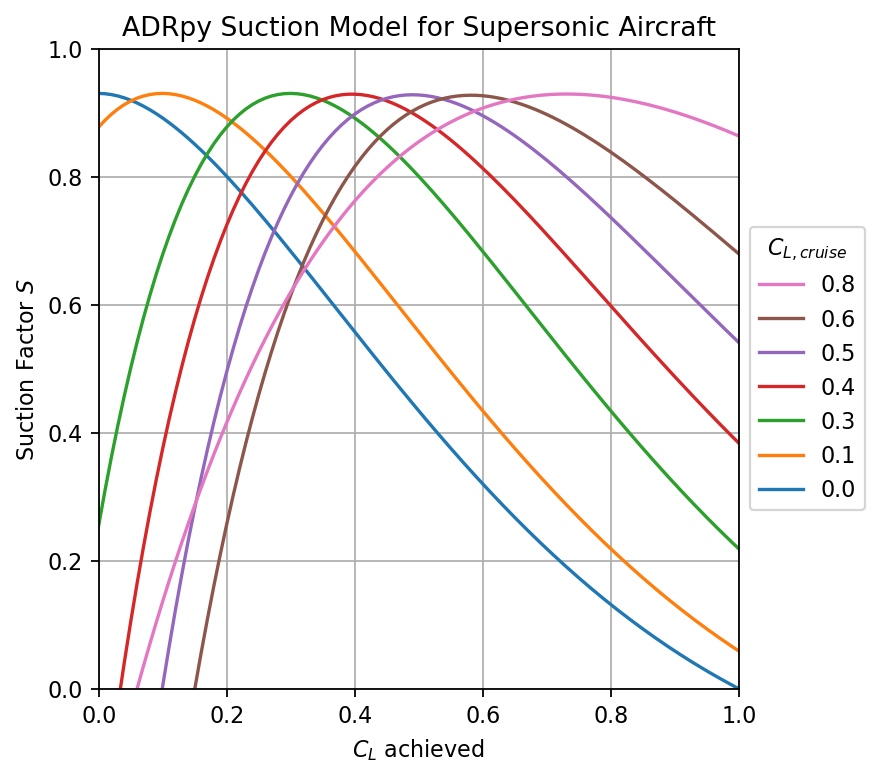

In [9]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1]) 

# Create predictions of new suction curves by weighting the sample curves
for cl_cruise in cl_cruise_array:
    weight = np.interp(cl_cruise, [0.3, 0.8], [1, 0])
    y_0x = weight * y_03 + (1 - weight) * y_08
    ax.plot((cl_achieved+cl_cruise), y_0x, label = str(cl_cruise))

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), title='$C_{L, cruise}$', loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_title('ADRpy Suction Model for Supersonic Aircraft')
ax.set(xlabel='$C_L$ achieved', ylabel='Suction Factor $S$')
ax.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

fig.clear()
plt.close(fig=fig)

Direct comparisons of the ADRpy model to Raymer's plot suggest the model can fairly accurately match the suction peak values, but tends to overpredict suction for smaller design $C_L$ and greater achieved $C_L$. Given these are typical design goal values for aircraft at the concept design stage, and not indicative of real-world performance metrics, the model is reasonably accurate for use in ADRpy.

#### Change of K bounding cases with Mach

A key aspect of $K$ is that it is a function of the flight Mach number $M$ (free-stream Mach number $M_{\infty}$). One of the reasons that this is the case, is because shock formation in the transonic regime reduces the maximum attainable suction, reaching 0% when the leading edge becomes supersonic:

$${M^*}_{LE} = \frac{M^*}{\cos \Lambda_{LE}}$$

$$K_{100} = \begin{cases}
M \leq M^*:  {(\pi AR)}^{-1}\\
M > {M^*}_{LE}: K_0\\
\end{cases} = f(M_{\infty})$$

where $M = M^* = 1$ is the sonic condition for the freestream, and $M = {M^*}_{LE}$ is the sonic condition for the leading edge of the wing.

Note that for $\Lambda_{LE} > 0$, $K_{100}$ is undefined for a free-stream mach between the sonic conditions $(M^* < M < {M^*}_{LE})$. This is by design, and it is suggested that for the concept stage, the value of $K_{100}$ in this transonic regime is best evaluated with a "that looks about right" curve-fit approach.

The other reason that $K = f(M)$, is that the lift-slope $C_{L_{\alpha}}$ of aerofoils/wings is dependent on Mach compressibility effects, amongst other parameters:

$$K_0 = \frac{1}{C_{L_{\alpha}}(M)} = f(M)$$

It becomes necessary for ADRpy to be able to predict the lift-slope of concept aircraft using the `liftslope` method. An example follows.

In [10]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

matplotlib.rcParams['figure.dpi'] = 160

mach_array = np.arange(0, 2, 0.001)

exconcept = ca.AircraftConcept(brief={}, design={}, performance={}, designatm={})

slopeslist = []
for mach_number in mach_array:
    slopeslist.append(exconcept.liftslope_prad(mach_number))

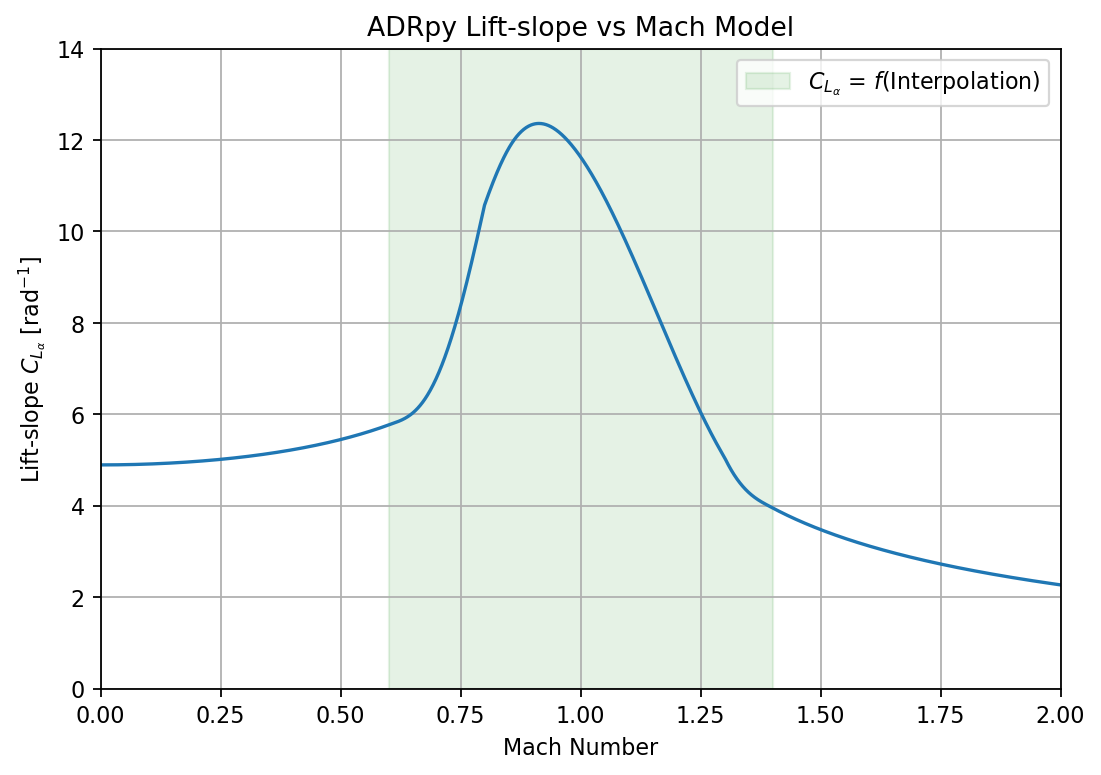

In [11]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1]) 

ax.plot(mach_array, slopeslist)
ax.fill([0.6, 0.6, 1.4, 1.4], [0, 14, 14, 0], color='green', alpha=0.1, label='$C_{L_{\\alpha}}$ = $f($Interpolation$)$')

ax.set_xlim(0, 2)
ax.set_ylim(0, 14)
ax.set_title('ADRpy Lift-slope vs Mach Model')
ax.set(xlabel='Mach Number', ylabel='Lift-slope $C_{L_{\\alpha}}$ [rad$^{-1}$]')
ax.legend()
ax.grid(True)
plt.show()

fig.clear()
plt.close(fig=fig)

Similar to the `induceddragfact` method that is also embedded within the `constraintanalysis` module, the lift-slope model is an aggregation of several empirical methods for estimating the lift-slope of real aircraft wings. These methods can not be called individually, and `liftslope` will always take an average of several methods. The region of Mach for which $M \in [0.8, 1.3]$ is typically referred to as the transonic flight regime, where classical techniques for finding the lift-slope encounter the Prandtl-Glauert singularity. The shaded region indicates where the model departs from theory and instead estimates the value of $C_{L_{\alpha}}$ from a weighted combination of theory, empirical models, and interpolation of the two.

#### Prediction of K

The information above is consolidated alongside oswald predictions of $K$, to produce a weighted average of both methods as a function of Mach number (preferring to use the $K_{LESM}$ method for $M \geq 1$). The resulting estimate of $K$ can be obtained by calling the `induceddragfact_lesm` method in the `constraintanalysis` module, and an example of its usage is demonstrated below.

In [12]:
import math

import numpy as np
import matplotlib
from matplotlib import pyplot as plt

matplotlib.rcParams['figure.dpi'] = 160

mach_array = np.arange(0, 2, 0.001)

exbrief = {'cruisealt_m': 12000, 'cruisespeed_ktas': 570}
exdef = {'aspectratio': 4, 'sweep_le_deg': 27, 'sweep_25_deg': 20, 'wingarea_m2': 38, 'weight_n': 23541 * 9.81}
exconcept = ca.AircraftConcept(brief=exbrief, design=exdef, performance={}, designatm={})

klist = []
k0list = []
k100list = [1.0 / (math.pi * exconcept.aspectratio)] * 2
for mach_number in mach_array:
    klist.append(exconcept.induceddragfact_lesm(mach_inf=mach_number, cl_real=0.455))
    k0list.append(1 / exconcept.liftslope_prad(mach_inf=mach_number))
    
machstar_le = 1 / math.cos(math.radians(exconcept.sweep_le_deg))

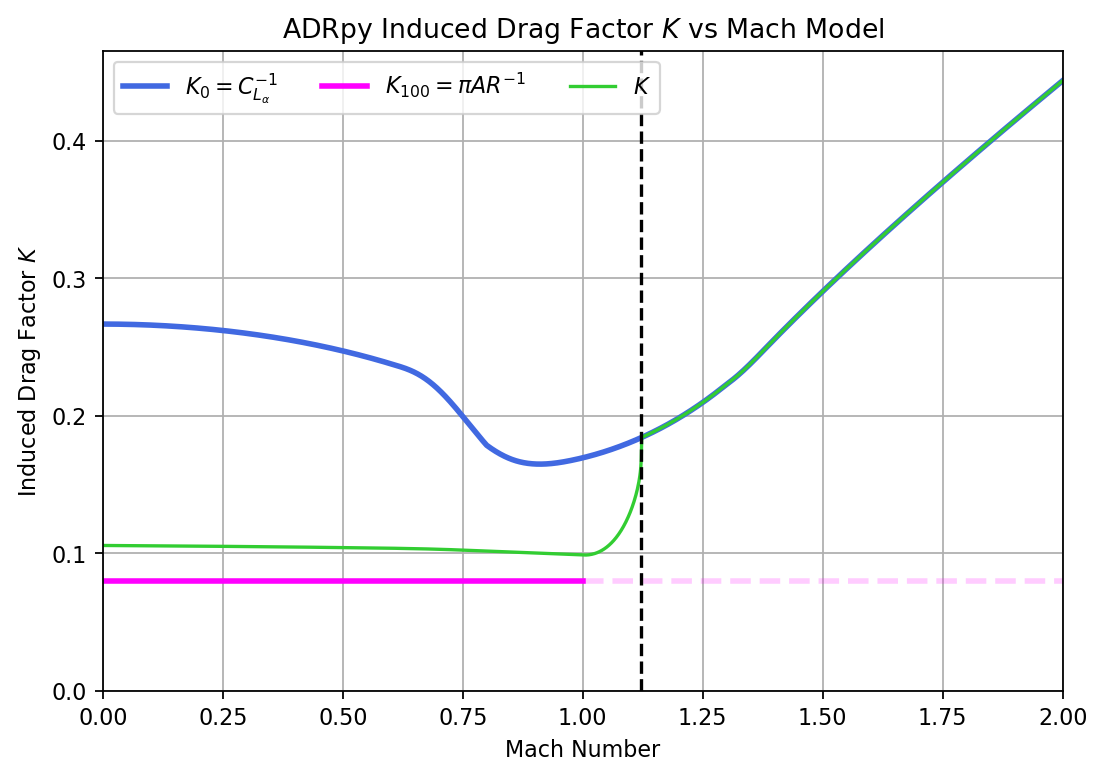

In [13]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1]) 

ax.plot(mach_array, k0list, label="$K_0 = C_{L_{\\alpha}}^{-1}$", lw=2.5, color='royalblue')
ax.plot(np.array([0, 1]), np.array(k100list), label="$K_{100} = \\pi AR^{-1}$", lw=2.5, color='magenta')
ax.plot(np.array([1, 2]), np.array(k100list), alpha=0.2, lw=2.5, ls='--', color='magenta')
ax.plot(mach_array, klist, label="$K$", color='limegreen')

ax.plot(np.array([machstar_le, machstar_le]), np.array([0, 1]), color='k', ls='--')

ax.set_xlim(0, 2)
ax.set_ylim(0, 1.05 * max(k0list))
ax.set_title('ADRpy Induced Drag Factor $K$ vs Mach Model')
ax.set(xlabel='Mach Number', ylabel='Induced Drag Factor $K$')
ax.grid(True)
ax.legend(loc='best', ncol=3)
plt.show()

fig.clear()
plt.close(fig=fig)

The dashed vertical black line indicates the LE sonic condition $M = {M^*}_{LE}$ where leading edge suction $S$ becomes 0%, and $K = K_0$.

There is no utility in the code for the backward-calculation of the Oswald efficiency factor, but a manual rain-check never hurts:

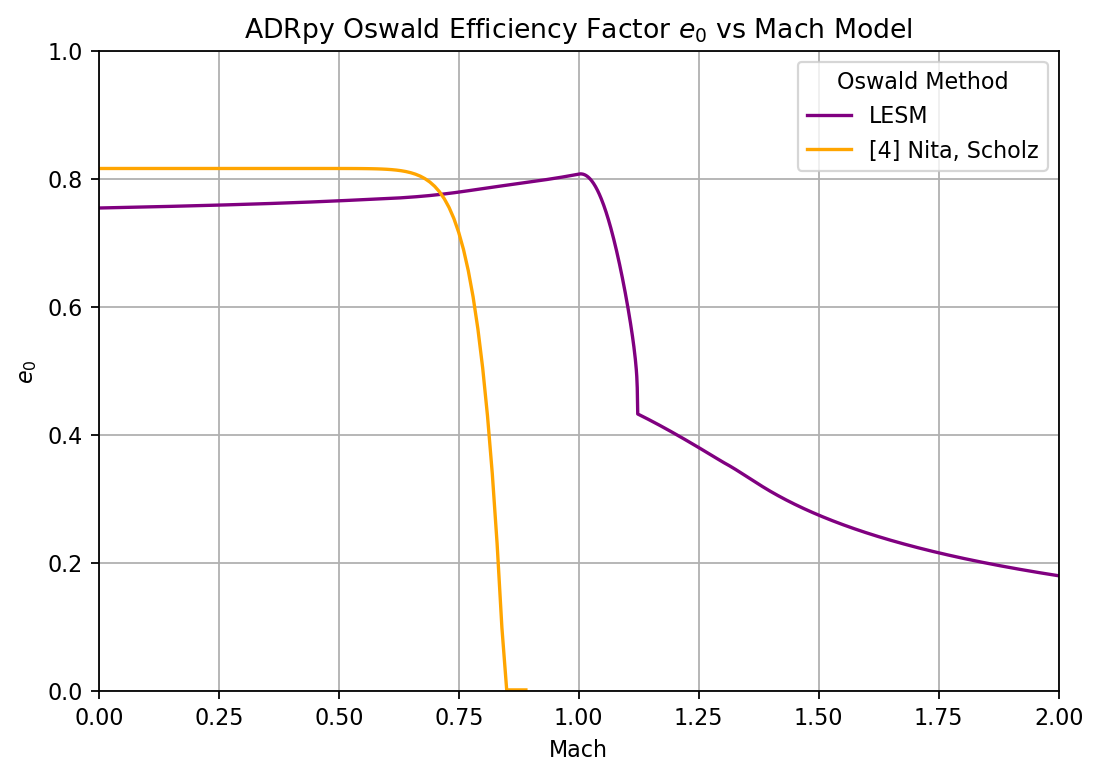

In [14]:
elist = []

for kfactor in klist:
    elist.append(1 / (math.pi * exconcept.aspectratio * kfactor))

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1]) 

ax.plot(mach_array, elist, label='LESM', c='purple')
ax.plot(mach_range, e4, label='[4] Nita, Scholz', c='orange')
ax.grid(True)
ax.set_title('ADRpy Oswald Efficiency Factor $e_0$ vs Mach Model')
ax.set(xlabel='Mach', ylabel='$e_0$')
ax.set_xlim(0, 2)
ax.set_ylim(0, 1)
ax.legend(title='Oswald Method', loc='best')
plt.show()

fig.clear()
plt.close(fig=fig)

The graph is in agreement with a comment in Raymer's publication, that the Oswald efficiency factor is approximately 0.3-0.5 at Mach 1.2.